In [2]:
#A simple analysis of Lending Club Loan Data to identify some of the factors leading to different interest rates.
#For portions of this (as noted) I worked with John Alvino

import pandas as pd
import pandas.io.data as iod
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import datetime as dt
%matplotlib inline

In [5]:
#The data can be pulled from Lending Club as a CSV
#When I completed this analysis it was published every couple of weeks
data_frame = pd.read_csv('treefo.csv', dtype=object)
data_frame.head()

,id,int_rate,loan_status,dti,delinq_2yrs,earliest_cr_line,pub_rec,out_prncp
0,36805548,6.99,Current,14.92,0,Sep-89,0,9877.48
1,38098114,12.39,Current,12.03,0,Aug-94,0,14634.59
2,37822187,13.66,Current,25.81,0,Nov-92,0,9163.03
3,37662224,13.66,Current,34.81,0,2-Aug,0,7301.79
4,37612354,17.14,Current,8.31,1,Oct-00,0,12525.55


In [7]:
#hat tip to John for this part
loan_data = list()
weights_dictionary={}

for loan_id in data_frame.iloc[0:235628]['id']:
    sub_df = data_frame.ix[data_frame.id== loan_id] 
    series_data = sub_df.iloc()[0]
    int_rate = series_data['int_rate']
    loan_status = series_data['loan_status']
    dti = series_data['dti']
    delinq = series_data['delinq_2yrs']
    earliest = series_data['earliest_cr_line']
    pub_records = series_data['pub_rec']
    try:
        earliest_v1= 2000 + int(earliest[0])
        try:
            int(earliest[1])
            earliest_v1= 2000+int(earliest[0:2])
        except:
            pass
    except:
        earliest_v1 = 1900 + int(earliest[4:6])
    if earliest_v1 == 1900:
        earliest_v1 = 2000
    #print(earliest_v1)

    earliest_v2=2015-earliest_v1
    
    loan_info = loan_id,int_rate,loan_status,dti,delinq,pub_records,earliest_v2
    loan_data.append(loan_info)

#print(loan_data)

    loan_list = list()
    if dti <  10:
        dti_value=1
    elif 10 < dti <  20:
        dti_value=2
    elif dti > 20:
        dti_value=3
    loan_list.append(dti_value)
    if delinq ==0:
        delinq_value=1
    elif delinq ==1:
        delinq_value=2
    elif delinq>1:
        delinq_value=3
    loan_list.append(delinq_value)
    if pub_records ==0:
        pub_records_value=1
    elif pub_records ==1:
        pub_records_value=2
    elif pub_records>1:
        pub_records_value=3
    loan_list.append(pub_records_value)
    if earliest_v2 >20:
        earliest_value=1
    elif 8 < earliest_v2 < 21:
        earliest_value=2
    elif earliest_v2 <9:
        earliest_value=3
    loan_list.append(earliest_value)
    weight_sum= (sum(loan_list))
    #print(loan_list)
    #print(weight_sum)
    weights_dictionary[loan_id]= weight_sum

#print(weights_dictionary)

low_risk_list=list()
med_low_risk_list=list()
med_risk_list=list()
med_hi_risk_list=list()
hi_risk_list=list()

for loan_id in weights_dictionary.keys():
    if weights_dictionary[loan_id] < 6:
        low_risk_list.append(loan_id)
    elif 5 < weights_dictionary[loan_id] < 7:
        med_low_risk_list.append(loan_id)
    elif 6 < weights_dictionary[loan_id] < 9:
        med_risk_list.append(loan_id)
    elif 8 < weights_dictionary[loan_id] < 11:
        med_hi_risk_list.append(loan_id)
    elif weights_dictionary[loan_id] > 10:
        hi_risk_list.append(loan_id)

In [118]:
low_frame = data_frame.ix[data_frame['id'].isin(low_risk_list)]
low_frame = low_frame[low_frame.out_prncp != 0] #make sure it has a positive balance to invest
low_frame.to_csv('low_frame.csv')

In [117]:
med_low_frame = data_frame.ix[data_frame['id'].isin(med_low_risk_list)]
med_low_frame = med_low_frame[med_low_frame.out_prncp != 0]
med_low_frame.to_csv('med_low_frame.csv')

In [119]:
med_risk_frame = data_frame.ix[data_frame['id'].isin(med_risk_list)]
med_risk_frame = med_risk_frame[med_risk_frame.out_prncp != 0]
med_risk_frame.to_csv('med_frame.csv')

In [120]:
med_hi_risk_frame = data_frame.ix[data_frame['id'].isin(med_hi_risk_list)]
med_hi_risk_frame = med_hi_risk_frame[med_hi_risk_frame.out_prncp != 0]
med_hi_risk_frame.to_csv('med_hi_frame.csv')

In [121]:
hi_risk_frame = data_frame.ix[data_frame['id'].isin(hi_risk_list)]
hi_risk_frame = hi_risk_frame[hi_risk_frame.out_prncp != 0]
hi_risk_frame.to_csv('hi_frame.csv')

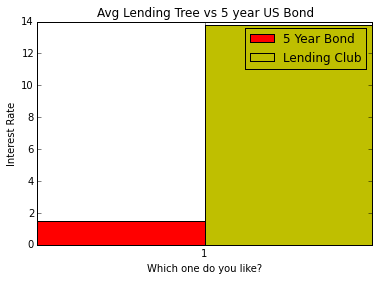

In [122]:
#Get the 5 year rate from yahoo and compare it to the average of Lending Club's Portfolio

int_mean = np.mean(data_frame['int_rate'])
int_mean
five_year_rate = iod.get_data_yahoo('^FVX', start=dt.datetime(2015,4,29), end=dt.date.today())
latest_day = len(five_year_rate) - 1
latest_day
five_year_plot=five_year_rate.iloc[latest_day]['Close']
five_year_plot

N = 1
plots=[five_year_plot,int_mean]
ind = np.arange(N)
width = 1
fig, ax = plt.subplots()
rects1 = ax.bar(ind, five_year_plot, width, color='r')
rects2 = ax.bar(ind+width, int_mean, width, color='y')
ax.set_ylabel('Interest Rate')
ax.set_xlabel('Which one do you like?')
ax.set_title('Avg Lending Tree vs 5 year US Bond')
ax.set_xticks(ind+width)
ax.legend( (rects1[0], rects2[0]), ('5 Year Bond', 'Lending Club'))


In [7]:
low_int_std = np.std(low_frame['int_rate'])
low_int_mean = np.mean(low_frame['int_rate'])
low_prin_mean = np.mean(low_frame['out_prncp'])
low_prin_sum = np.sum(low_frame['out_prncp'])

In [8]:
med_low_int_std = np.std(med_low_frame['int_rate'])
med_low_int_mean = np.mean(med_low_frame['int_rate'])
med_low_prin_mean = np.mean(med_low_frame['out_prncp'])
med_low_prin_sum = np.sum(med_low_frame['out_prncp'])

In [11]:
med_risk_int_std = np.std(med_risk_frame['int_rate'])
med_risk_int_mean = np.mean(med_risk_frame['int_rate'])
med_risk_prin_mean = np.mean(med_risk_frame['out_prncp'])
med_risk_prin_sum = np.sum(med_risk_frame['out_prncp'])

In [14]:
med_hi_int_std = np.std(med_hi_risk_frame['int_rate'])
med_hi_int_mean = np.mean(med_hi_risk_frame['int_rate'])
med_hi_prin_mean = np.mean(med_hi_risk_frame['out_prncp'])
med_hi_prin_sum = np.sum(med_hi_risk_frame['out_prncp'])

In [15]:
hi_int_std = np.std(hi_risk_frame['int_rate'])
hi_int_mean = np.mean(hi_risk_frame['int_rate'])
hi_prin_mean = np.mean(hi_risk_frame['out_prncp'])
hi_prin_sum = np.sum(hi_risk_frame['out_prncp'])

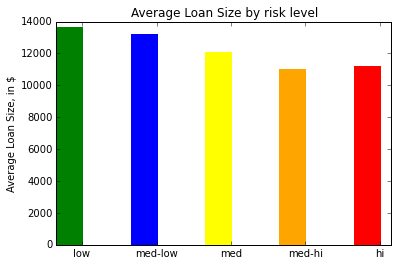

In [128]:
#Check to see if we are in the right ballpark with our analysis ...
N = 5
intmeans = (low_prin_mean,med_low_prin_mean,med_risk_prin_mean,med_hi_prin_mean,hi_prin_mean)

ind = np.arange(N)  
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind, intmeans, width)
rects1[0].set_color('green')
rects1[1].set_color('blue')
rects1[2].set_color('yellow')
rects1[3].set_color('orange')
rects1[4].set_color('red')

ax.set_ylabel('Average Loan Size, in $')
ax.set_title('Average Loan Size by risk level')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('low','med-low','med','med-hi','hi') )

plt.show()

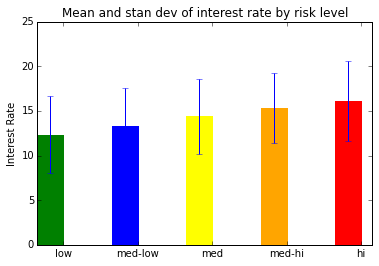

In [129]:
#Mean and Standard Deviation ...
N = 5
intmeans = (low_int_mean,med_low_int_mean,med_risk_int_mean,med_hi_int_mean,hi_int_mean)
intstds =   (low_int_std,med_low_int_std,med_risk_int_std,med_hi_int_std,hi_int_std)

ind = np.arange(N)  
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind, intmeans, width, color='r', yerr=intstds)
rects1[0].set_color('green')
rects1[1].set_color('blue')
rects1[2].set_color('yellow')
rects1[3].set_color('orange')
rects1[4].set_color('red')

ax.set_ylabel('Interest Rate')
ax.set_title('Mean and stan dev of interest rate by risk level')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('low','med-low','med','med-hi','hi') )

plt.show()

In [139]:
top_5_low = low_frame.sort(['int_rate'], ascending=False)
top_5_low = top_5_low[0:5]
top_5_low.to_csv('top_5_low_frame.csv')

top_5_med_low = med_low_frame.sort(['int_rate'], ascending=False)
top_5_med_low = top_5_med_low[0:5]
top_5_med_low.to_csv('top_5_med_low.csv')

top_5_med = med_risk_frame.sort(['int_rate'], ascending=False)
top_5_med = top_5_med[0:5]
top_5_med.to_csv('top_5_med.csv')

top_5_med_hi = med_hi_risk_frame.sort(['int_rate'], ascending=False)
top_5_med_hi = top_5_med_hi[0:5]
top_5_med_hi.to_csv('top_5_med_hi.csv')

top_5_hi = hi_risk_frame.sort(['int_rate'], ascending=False)
top_5_hi = top_5_hi[0:5]
top_5_hi.to_csv('top_5_hi.csv')

In [13]:
low_frame = pd.read_csv('low_frame.csv')
med_low_frame = pd.read_csv('med_low_frame.csv')
med_risk_frame = pd.read_csv('med_frame.csv')
med_hi_risk_frame = pd.read_csv('med_hi_frame.csv')
hi_risk_frame = pd.read_csv('med_hi_frame.csv')

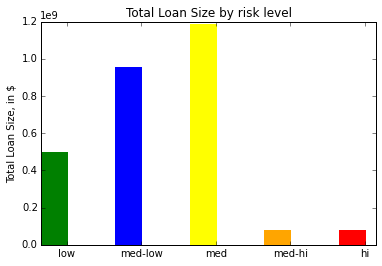

In [16]:
#Checking the size of the loan and graphing it.
N = 5
amtsums = (low_prin_sum,med_low_prin_sum,med_risk_prin_sum,med_hi_prin_sum,hi_prin_sum)

ind = np.arange(N)  
width = 0.35       

fig, ax = plt.subplots()
rects1 = ax.bar(ind, amtsums, width)
rects1[0].set_color('green')
rects1[1].set_color('blue')
rects1[2].set_color('yellow')
rects1[3].set_color('orange')
rects1[4].set_color('red')

ax.set_ylabel('Total Loan Size, in $')
ax.set_title('Total Loan Size by risk level')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('low','med-low','med','med-hi','hi') )

plt.show()

In [115]:
#get the top loans from any risk category (low the example below)
top_5_low = low_frame.sort(['int_rate'], ascending=False)